# Live Tests and Routines for Conical Refraction Characterization

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipyfilechooser import FileChooser
import os
os.chdir(f"../../..")
path=f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/"

Both for the 3D profile and linear profile computations you can choose the input image here

In [2]:
# Create and display a FileChooser widget
fc = FileChooser(path+'/Experimental_Stuff/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/')
display(fc)

FileChooser(path='/home/oiangu/Desktop/Conical_Refraction_Polarimeter/Experimental_Stuff/Fotos_Turpin/Day2/las…

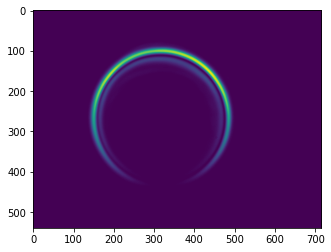

In [3]:
image_full_path=fc.selected
#image_full_path="/home/oiangu/Desktop/Conical_Refraction_Polarimeter/Experimental_Stuff/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_el_positivo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)
if im is None:
    print(f" Unable to import image {image_full_path}")
    raise ValueError
plt.imshow(im)
plt.show()

## Get 3D profile

<IPython.core.display.Javascript object>


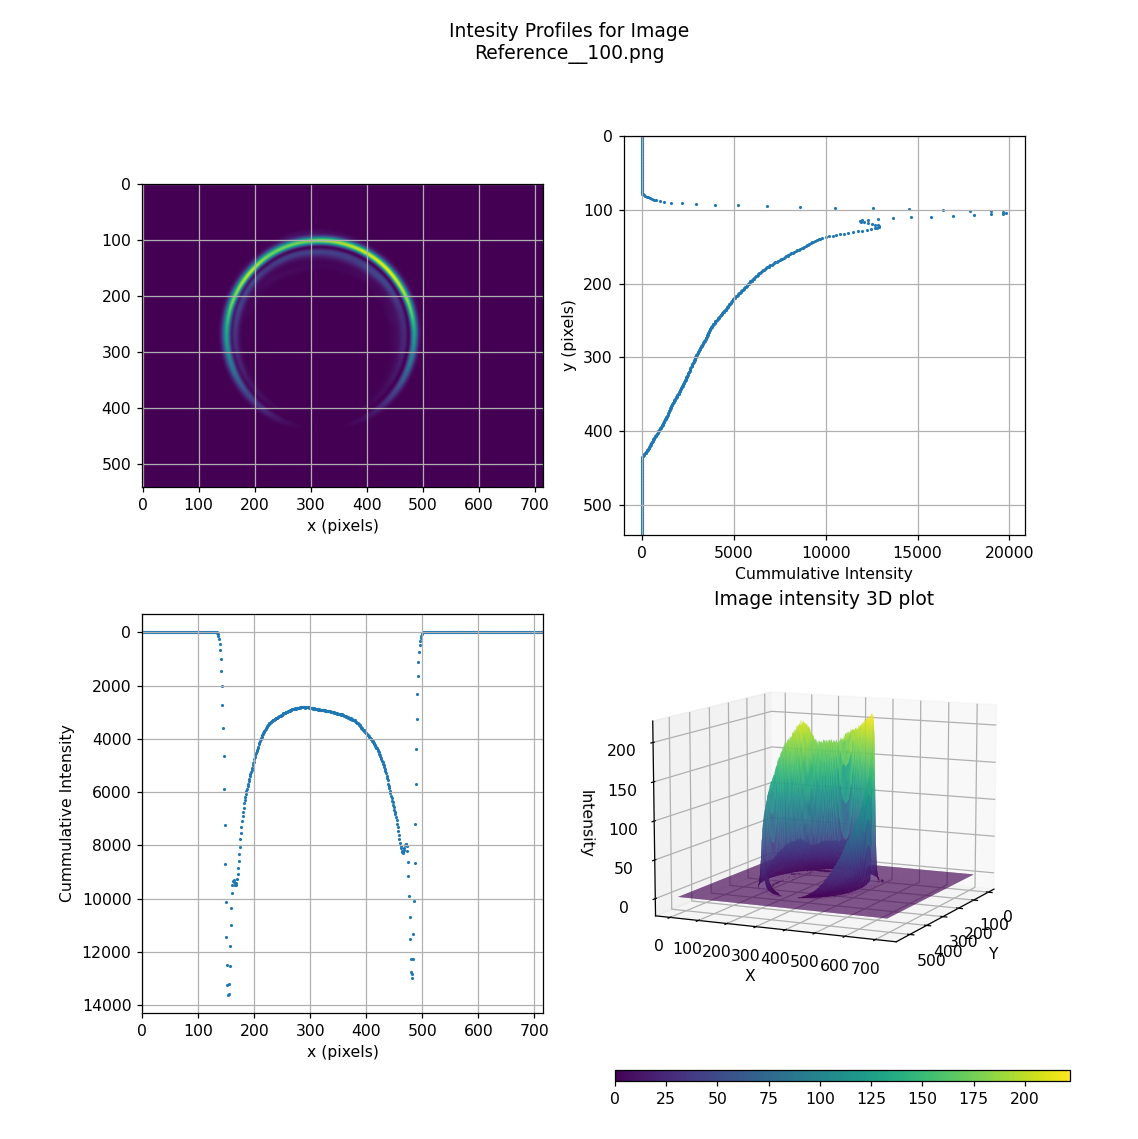

In [4]:
plot3d_resolution=0.7

%matplotlib notebook

prof_x=np.sum(im, axis=0)
prof_y=np.sum(im, axis=1)
fig = plt.figure(figsize=(2*4.5, 2*4.5))
axes=fig.subplots(2,2)
cm=axes[0, 0].imshow(im, cmap='viridis')
axes[0,0].grid(True)
axes[0,1].scatter(prof_y, np.arange(len(prof_y)), s=1, label=f'Intensity profile in y')
axes[0,1].set_ylim((0,len(prof_y)))
axes[0,1].invert_yaxis()
axes[1,0].scatter(np.arange(len(prof_x)), prof_x, s=1, label=f'Intensity profile in y')
axes[1,0].set_xlim((0,len(prof_x)))
axes[1,0].invert_yaxis()
axes[0,0].set_xlabel("x (pixels)")
#axes[0,0].set_ylabel("y (pixels)")
axes[0,1].set_xlabel("Cummulative Intensity")
axes[0,1].set_ylabel("y (pixels)")
axes[1,0].set_ylabel("Cummulative Intensity")
axes[1,0].set_xlabel("x (pixels)")
axes[1,0].grid(True)
axes[0,1].grid(True)
axes[1,1].set_visible(False)
ax = fig.add_subplot(224, projection='3d')
X,Y = np.meshgrid(np.arange(len(prof_y)),np.arange(len(prof_x)))
fig.suptitle(f"Intesity Profiles for Image\n{image_full_path.split('/')[-1]}")
files_for_gif=[]
cbax=fig.add_axes([0.54,0.05,0.4,0.01])
fig.colorbar(cm, ax=axes[0,0], cax=cbax, orientation='horizontal')
theta=25
phi=30
ax.plot_surface(X, Y, im.T, rcount=int(len(prof_y)*plot3d_resolution), ccount=int(len(prof_x)*plot3d_resolution), cmap='viridis') # rstride=1, cstride=1, linewidth=0
#cset = ax.contourf(X, Y, im, 2, zdir='z', offset=-20, cmap='viridis', alpha=0.5)
#cset = ax.contourf(X, Y, im, 1, zdir='x', offset=-8, cmap='viridis')
#cset = ax.contourf(X, Y, im, 1, zdir='y', offset=0, cmap='viridis')
ax.set_xlabel('Y')
#ax.set_xlim(-8, 8)
ax.set_ylabel('X')
#ax.set_ylim(-10, 8)
ax.set_zlabel('Intensity')
ax.set_zlim(-0.078*np.max(im), np.max(im))
ax.set_title("Image intensity 3D plot")
ax.view_init(10, theta)
#ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.3, 1.3, 1.3, 1]))
plt.show()

## Know the $w_0$ coeff

In [12]:
import os
os.chdir(f"../../..")
import sys
from SOURCE.CLASS_CODE_GPU_Classes import *
from SOURCE.CLASS_CODE_Image_Manager import *
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm, Gradient_Algorithm, Simulation_fixed_R0_w0_Z_optimize_phiCR_precomputed_library
import numpy as np
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt

image=im.copy()
saturation=0.05
pol_or_CR="pol" 
deg_or_rad="deg" # for the final output
image_depth=8 # or 16 bit per pixel
image_shortest_side=540
randomization_seed=666
recenter_average_image=False


# 4. GRAVICENTER iX and PROFILES ######################################
X=int(image_shortest_side*1.4/2)
plot_3d_finnes=0.3 # value that should go in (0,1]. 1 means all the pixels will be ploted in the 3d plot, 0.5 only half of them



# 5. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Also a gradient algorithm
#library_of_theoretical_path = None
library_of_theoretical_path = "./OUTPUT/LIBRARIES_OF_THEORETICAL_CR/Basler_like_R0_153_w0_11_3th_decimal/STRUCTURE_Grid.json"
theta_min_Rot=-np.pi
theta_max_Rot=np.pi
rad_min_Grav=3
rad_max_Grav=image_shortest_side/2
theta_min_Mir=0
theta_max_Mir=np.pi
theta_min_Sim=-np.pi
theta_max_Sim=np.pi
initial_guess_delta_rad=0.1
initial_guess_delta_pix=10
use_exact_gravicenter=True
precision_quadratic=1e-10
max_it_quadratic=100
cost_tolerance_quadratic=1e-14
precision_fibonacci=1e-10
max_points_fibonacci=100
cost_tolerance_fibonacci=1e-14
interpolation_flag = cv2.INTER_CUBIC
similarity='mae' # for the simulation grid algorithm


##################################################################
##################################################################
im_type=np.uint16 if image_depth==16 else np.uint8
max_intensity=65535 if image_depth==16 else 255
np.random.seed(randomization_seed)
polCR=1 if pol_or_CR=='CR' else 0.5

# 4. GRAVICENTER iX ###############################
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_raw_to_centered_iX(image, X):

    g_raw = compute_intensity_gravity_center(image)
    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ 2 (h,w)]
    unclipped_lower = g_index_raw[:]-X
    unclipped_upper = g_index_raw[:]+X+1
    # unclippde could get out of bounds for the indices, so we clip them
    lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
    upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    centered_image[padding_lower[0]:padding_upper[0] or None,
                                    padding_lower[1]:padding_upper[1] or None ] = \
                  image[lower_bound[0]:upper_bound[0],
                                      lower_bound[1]:upper_bound[1]]
    return centered_image
    '''
    else:
        # We compute the center of gravity of the cropped images, if everything was made allright
        # they should get just centered in the central pixels number X+1 (index X)
        g_centered = compute_intensity_gravity_center(centered_image)

        # We now compute a floating translation of the image so that the gravicenter is exactly
        # centered at pixel (607.5, 607.5) (exact center of the image in pixel coordinates staring
        # form (0,0) and having size (607*2+1)x2), instead of being centered at the beginning of
        # around pixel (607,607) as is now
        translate_vectors = X+0.5-g_centered #[ 2(h,w)]
        T = np.float64([[1,0, translate_vectors[1]], [0,1, translate_vectors[0]]])
        return cv2.warpAffine( centered_image, T, (X*2+1, X*2+1),
                    flags=interpolation_flag) # interpolation method
    '''
# normalize the image
image = max_intensity*(image.astype(np.float64)/image.max())
image = np.where( image<=(max_intensity*saturation), image, max_intensity*saturation)
image = compute_raw_to_centered_iX(image, X)
# saturated and iX

# 6. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Results will be gathered in a table and outputed as an excel csv
# Mock Image Loader
# Computar el angulo de cada uno en un dataframe donde una de las entradas sea results y haya un result per fibo qfs y per rotation y mirror affine. Y luego procesar en un 7º paso estos angulos para obtener los angulos relativos etc y perhaps hacer tablucha con ground truth menos el resulting delta angle medido por el algoritmo
image_loader = Image_Manager(mode=X, interpolation_flag=None)
# Define the ROTATION ALGORITHM
rotation_algorithm = Rotation_Algorithm(image_loader,
    theta_min_Rot, theta_max_Rot, None,
    initial_guess_delta_rad, use_exact_gravicenter, initialize_it=False)

# Define the Affine Mirror algorithm
mirror_algorithm = Mirror_Flip_Algorithm(image_loader,
    theta_min_Mir, theta_max_Mir, None,
    initial_guess_delta_rad, method="aff", left_vs_right=True, use_exact_gravicenter=use_exact_gravicenter, initialize_it=False)

# Define the Gradient algorithm
gradient_algorithm = Gradient_Algorithm(image_loader,
        rad_min_Grav, rad_max_Grav,
        initial_guess_delta_pix,
        use_exact_gravicenter)

if library_of_theoretical_path!=None:
    # Define the Simulation Library Algorithm
    simulation_library_alg=Simulation_fixed_R0_w0_Z_optimize_phiCR_precomputed_library(
        image_loader, use_exact_gravicenter, library_of_theoretical_path, 
        theta_min_Sim, theta_max_Sim, initial_guess_delta_rad, 
        relative_saturation=saturation, similarity=similarity)
    #simulation_library_alg.precision=0.001

# A dictionary to gather all the resulting angles for each image

individual_image_results = { 'polarization_method':[], 'optimization_1d':[], 'found_phiCR':[], 'predicted_opt_precision':[] }

def to_result_dict(result_dict, alg, alg_name, opt_name, im_names):
    for key, name in zip(alg.times.keys(), im_names):
        result_dict['polarization_method'].append(alg_name)
        result_dict['optimization_1d'].append(opt_name)
        result_dict['found_phiCR'].append(alg.angles[key])
        result_dict['predicted_opt_precision'].append(alg.precisions[key])
image_container=np.zeros( (1, 2*X+1, 2*X+1), dtype=np.float64)
image_names=[]
# charge the image
image_container[0]=image.astype(np.float64)
image_names.append(f"{fc.selected_filename}")

# charge the image loader:
image_loader.import_converted_images_as_array(image_container, image_names)
# Execute the Rotation and Mirror Algorithms:
# ROTATION ######
interpolation_flag=None
# the interpolation algorithm used in case we disbale its usage for the iX image obtention will be the Lanczos one
rotation_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Quadratic", image_names)
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Fibonacci", image_names)

# MIRROR #######
mirror_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Quadratic", image_names)
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Fibonacci", image_names)

if library_of_theoretical_path is not None:
    # SIMULATION LIBRARY ###########
    simulation_library_alg.reInitialize(image_loader)
    simulation_library_alg.quadratic_fit_search(max_it_quadratic, cost_tolerance_quadratic)
    to_result_dict( individual_image_results, simulation_library_alg, "Simulation_Grid", "Quadratic", image_names)
    simulation_library_alg.reInitialize(image_loader)
    simulation_library_alg.fibonacci_ratio_search( max_points_fibonacci, cost_tolerance_fibonacci)
    to_result_dict( individual_image_results, simulation_library_alg, "Simulation_Grid", "Fibonacci", image_names)


# GRADIENT #######
optimal_masked_gravs={}
optimal_radii={}
grav=compute_intensity_gravity_center(image)

gradient_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Quadratic", image_names)
optimal_masked_gravs['quad'] = gradient_algorithm.masked_gravs[f"Quadratic_Search_{fc.selected_filename}"]
optimal_radii['quad'] = gradient_algorithm.optimals[f"Quadratic_Search_{fc.selected_filename}"]

gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Fibonacci", image_names)

optimal_masked_gravs['fibo'] = gradient_algorithm.masked_gravs[f"Fibonacci_Search_{fc.selected_filename}"]
optimal_radii['fibo'] = gradient_algorithm.optimals[f"Fibonacci_Search_{fc.selected_filename}"]

masked_grav=(optimal_masked_gravs['quad']+optimal_masked_gravs['fibo'])/2.0
optimal_radi = (optimal_radii['quad']+optimal_radii['fibo'])/2
print(f"\n\nOptimal masked gravs: {optimal_masked_gravs}\nOptimal radii: {optimal_radii}\n\n\n")
print(pd.DataFrame.from_dict(individual_image_results))

# 7. PROCESS FINAL RESULTS ##########################################
def angle_to_pi_pi( angle): # convert any angle to range ()-pi,pi]
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle    

average_found_phiCR=np.mean([angle_to_pi_pi(phi) for i,phi in enumerate(individual_image_results['found_phiCR']) if individual_image_results['polarization_method'][i]!='Gradient'])





Optimal masked gravs: {'quad': array([300.10906404, 381.83361904]), 'fibo': array([300.11364305, 381.81490515])}
Optimal radii: {'quad': 125.4388, 'fibo': 126.375626309875}



  polarization_method optimization_1d  found_phiCR  predicted_opt_precision
0            Rotation       Quadratic     1.554362             3.000000e-08
1            Rotation       Fibonacci     1.554489             4.100000e-11
2              Mirror       Quadratic     1.554489             4.100000e-11
3              Mirror       Fibonacci     1.554489             4.100000e-11
4     Simulation_Grid       Quadratic     3.000000             3.100000e+00
5     Simulation_Grid       Fibonacci     1.570198             2.800000e-06
6            Gradient       Quadratic     1.525533             2.500000e-03
7            Gradient       Fibonacci     1.525772             4.900000e-11


/home/oiangu/Desktop/Conical_Refraction_Polarimeter/SOURCE/Polarization_Obtention_Algorithms.py:603: RuntimeWarning: invalid value encountered in double_scalars
  new_grav = np.nan_to_num([np.dot(intensity_in_h, np.arange(circle.shape[0]))/total_intensity,
/home/oiangu/Desktop/Conical_Refraction_Polarimeter/SOURCE/Polarization_Obtention_Algorithms.py:604: RuntimeWarning: invalid value encountered in double_scalars
  np.dot(intensity_in_w, np.arange(circle.shape[1]))/total_intensity], nan=self.mode) # The nan to this number works only because the gravicenter is never exctly centered there, else the cost function would yield 0 and the three intial points would be aligned


Similarity mse, Opt Quad, Found_phiCR 1.568122


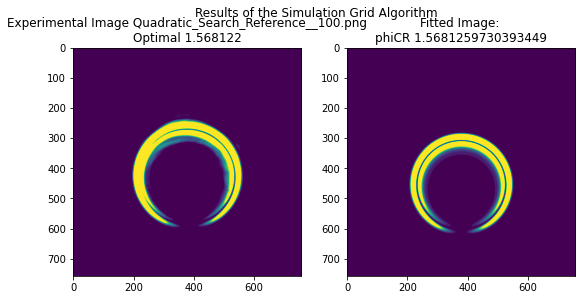

Similarity mse, Opt Fibo, Found_phiCR 1.5691676


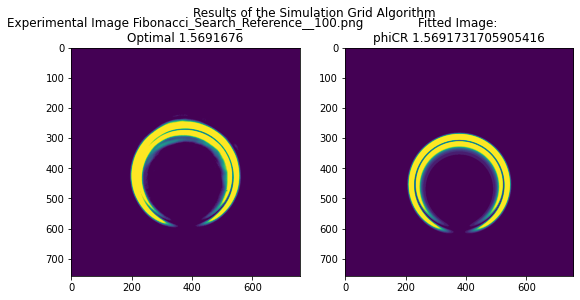

Similarity mae, Opt Quad, Found_phiCR 1.569293


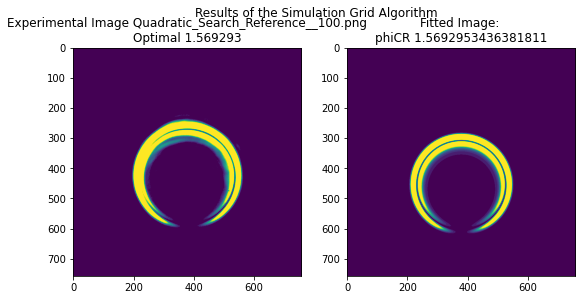

Similarity mae, Opt Fibo, Found_phiCR 1.5800326


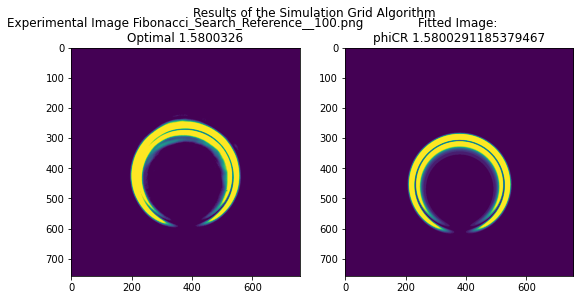

Similarity ssim, Opt Quad, Found_phiCR 1.5693353071795864


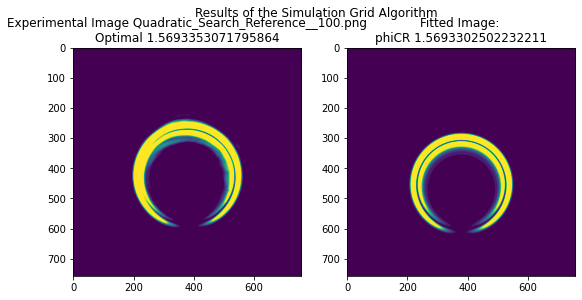

Similarity ssim, Opt Fibo, Found_phiCR 1.569239


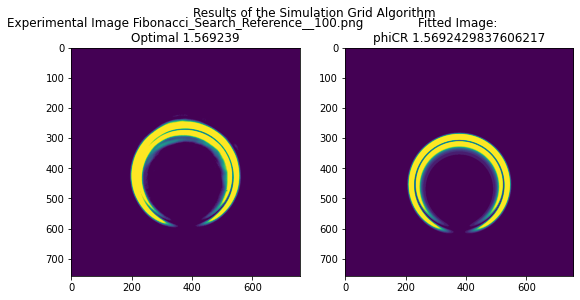

Similarity sre, Opt Quad, Found_phiCR 3.1


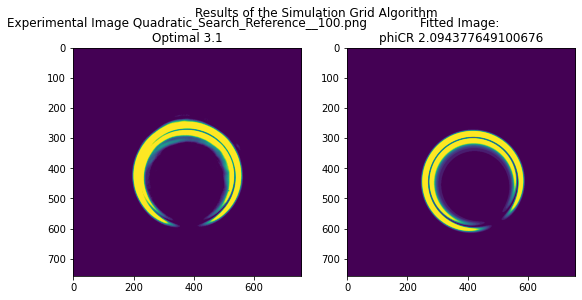

Similarity sre, Opt Fibo, Found_phiCR 1.5697871


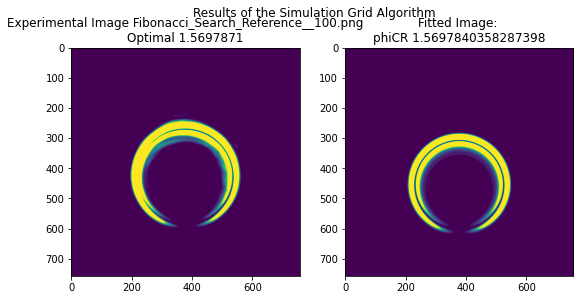




The best found average angle with the Rotation and the Mirror algorithms was: 1.5544574844744485
  Similarity_Index Optimization_Method  Found_phiCR  Time
0              mse           Quadratic     1.568122  0.18
1              mse           Fibonacci     1.569168  0.19
2              mae           Quadratic     1.569293  0.18
3              mae           Fibonacci     1.580033  0.27
4             ssim           Quadratic     1.569335  4.10
5             ssim           Fibonacci     1.569239  5.80
6              sre           Quadratic     3.100000  0.15
7              sre           Fibonacci     1.569787  0.18


In [9]:
# Let us check all the results with each different similarity index
results={'Similarity_Index':[], 'Optimization_Method':[], 'Found_phiCR':[], 'Time':[]}

for sim in ['mse', 'mae', 'ssim', 'sre']: # 'fsim', 'issm', 'sam', , 'uiq'
    simulation_library_alg.reInitialize(image_loader, similarity=sim)
    simulation_library_alg.quadratic_fit_search(max_it_quadratic, cost_tolerance_quadratic)
    results['Similarity_Index'].append(sim)
    results['Optimization_Method'].append('Quadratic')
    results['Time'].append(simulation_library_alg.times[f"Quadratic_Search_{fc.selected_filename}"])
    results['Found_phiCR'].append(simulation_library_alg.optimals[f"Quadratic_Search_{fc.selected_filename}"])
    print(f"Similarity {sim}, Opt Quad, Found_phiCR {results['Found_phiCR'][-1]}")
    simulation_library_alg.plot_best_found_ones()

    simulation_library_alg.reInitialize(image_loader, similarity=sim)
    simulation_library_alg.fibonacci_ratio_search(max_points_fibonacci, cost_tolerance_fibonacci)
    results['Similarity_Index'].append(sim)
    results['Optimization_Method'].append('Fibonacci')
    results['Time'].append(simulation_library_alg.times[f"Fibonacci_Search_{fc.selected_filename}"])
    results['Found_phiCR'].append(simulation_library_alg.optimals[f"Fibonacci_Search_{fc.selected_filename}"])
    print(f"Similarity {sim}, Opt Fibo, Found_phiCR {results['Found_phiCR'][-1]}")
    simulation_library_alg.plot_best_found_ones()

print(f"\n\n\nThe best found average angle with the Rotation and the Mirror algorithms was: {np.mean([angle_to_pi_pi(phi) for i,phi in enumerate(individual_image_results['found_phiCR']) if (individual_image_results['polarization_method'][i] not in ['Gradient', 'Simulation_Grid'] )])}")
print(pd.DataFrame.from_dict(results))


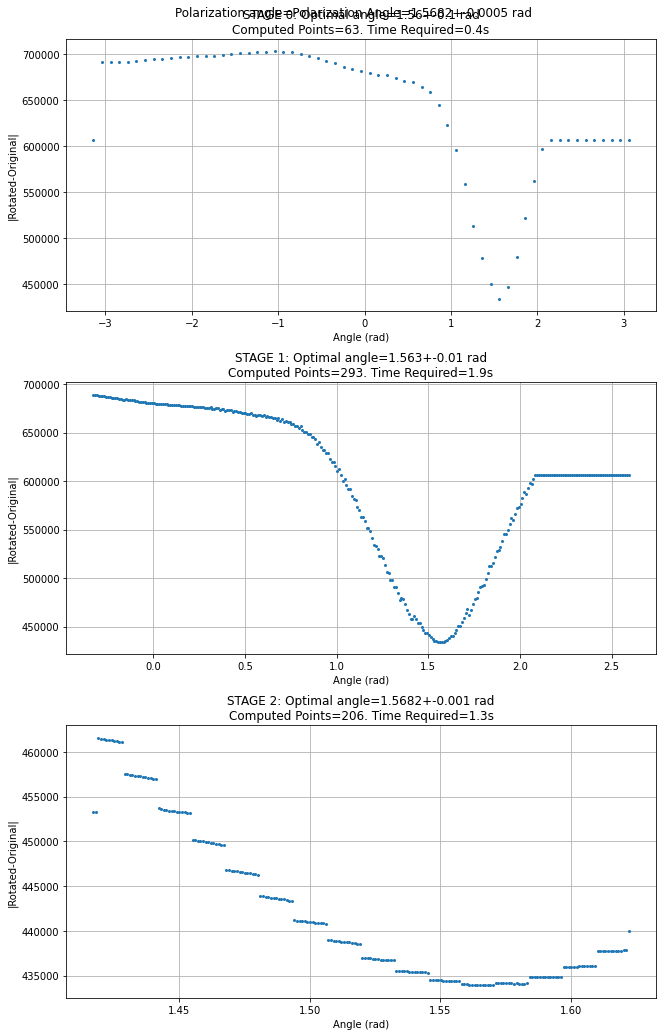

In [13]:
# Make a brute force search of the Simualtion library algorithm
%matplotlib inline
simulation_library_alg.reInitialize(image_loader, similarity='mae')
simulation_library_alg.brute_force_search([0.1, 0.01, 0.001], [0.6, 0.1, 0.1])
simulation_library_alg.save_result_plots_brute_force(f"./OUTPUT/")

In [14]:
(1.5642+1.568)-np.pi

-0.00939265358979302

<IPython.core.display.Javascript object>


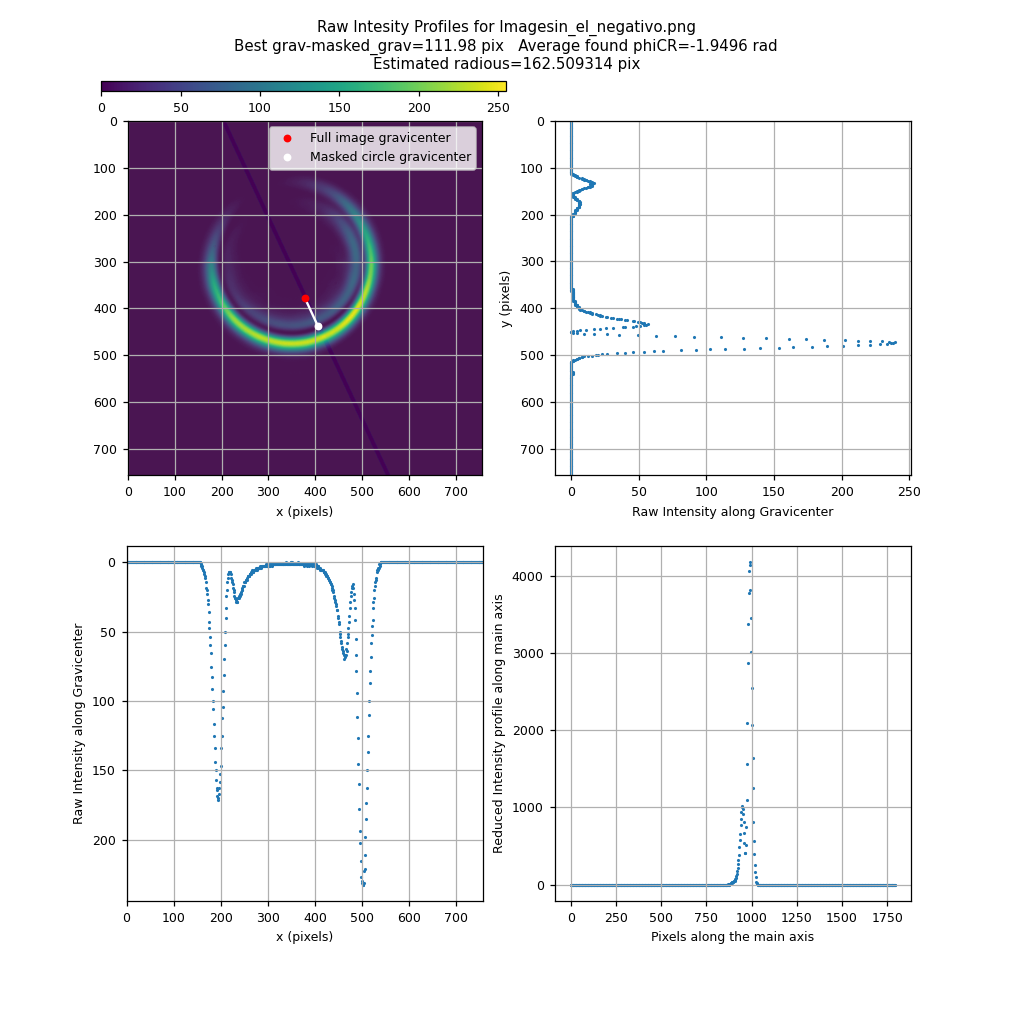

In [6]:
# PLOT THE PROFILES #################################################
pix_spacing=10
%matplotlib notebook

plt.rc('font', size=8) 

prof_x=image[int(grav[0])]
prof_y=image[:,int(grav[1])]
fig = plt.figure(figsize=(2*4.5, 2*4.5))
axes=fig.subplots(2,2)
cm=axes[0, 0].imshow(image.astype(im_type), cmap='viridis')
axes[0,0].plot([grav[1],masked_grav[1]], [grav[0], masked_grav[0]], '-w', markersize=1)
axes[0,0].plot(grav[1], grav[0], 'or', markersize=4, label="Full image gravicenter")
axes[0,0].plot(masked_grav[1], masked_grav[0], 'ow', markersize=4, label="Masked circle gravicenter")
axes[0,0].legend()
axes[0,0].grid(True)
axes[0,1].scatter(prof_y, np.arange(len(prof_y)), s=1, label=f'Intensity profile in y')
axes[0,1].set_ylim((0,len(prof_y)))
axes[0,1].invert_yaxis()
axes[1,0].scatter(np.arange(len(prof_x)), prof_x, s=1, label=f'Intensity profile in x')
axes[1,0].set_xlim((0,len(prof_x)))
axes[1,0].invert_yaxis()
axes[0,0].set_xlabel("x (pixels)")
#axes[0,0].set_ylabel("y (pixels)")
axes[0,1].set_xlabel("Raw Intensity along Gravicenter")
axes[0,1].set_ylabel("y (pixels)")
axes[1,0].set_ylabel("Raw Intensity along Gravicenter")
axes[1,0].set_xlabel("x (pixels)")
axes[1,0].grid(True)
axes[0,1].grid(True)

cols = np.broadcast_to( np.arange(X*2+1), (X*2+1,X*2+1)) #[h,w]
rows = cols.swapaxes(0,1) #[h,w]
slope=(masked_grav[0]-grav[0])/(masked_grav[1]-grav[1])
mask=(rows<( slope*(cols-masked_grav[1]) +masked_grav[0]+pix_spacing )) & (rows>( slope*(cols-masked_grav[1]) +masked_grav[0]-pix_spacing ))

filtered_image=np.where(mask, image, 0)
filtered_line=np.where(mask, image, 200)
axes[0,0].imshow(filtered_line.astype(im_type), alpha=0.1, label="Optimal Radious Mask")
prof_filt=np.sum(filtered_image,axis=0)
axes[1,1].scatter(np.arange(len(prof_filt))*np.sqrt(1+slope**2), prof_filt , s=1, label=f'Intensity profile along main axis')
axes[1,1].grid()
axes[1,1].set_ylabel(f'Reduced Intensity profile along main axis')
axes[1,1].set_xlabel("Pixels along the main axis") 
fig.suptitle(f"Raw Intesity Profiles for Image{fc.selected_filename}\nBest grav-masked_grav={optimal_radi:3.5} pix   Average found phiCR={average_found_phiCR:3.5} rad\nEstimated radious={optimal_radi/0.689095:4.9} pix")
cbax=fig.add_axes([0.1,0.91,0.4,0.01])
fig.colorbar(cm, ax=axes[0,0], cax=cbax, orientation='horizontal')

plt.show()

## Run Angle Determination

In [21]:
import os
os.chdir(f"../../..")
import sys
from SOURCE.CLASS_CODE_GPU_Classes import *
from SOURCE.CLASS_CODE_Image_Manager import *
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm, Simulation_fixed_R0_w0_Z_optimize_phiCR_precomputed_library
import numpy as np
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from styleframe import StyleFrame


import glob
%matplotlib inline


def run_angle_live(output_path, ground_truth, saturation, library_of_theoretical_path):

    reference_directory=output_path+f"/Reference"
    problem_directory=output_path+f"/Problem"
    image_shortest_side=540

    #ground_truth=-13.85 # if deg selected then input ground truth in deg, else in rad
    pol_or_CR="pol"
    deg_or_rad="deg" # for the final outputs
    image_depth=8 # or 16 bit per pixel
    randomization_seed=666
    use_interpolation=False
    recenter_average_image=False

    # 4. GRAVICENTER iX and PROFILES ######################################
    X=int(image_shortest_side*1.4/2)
    interpolation_flags={"CUBIC":cv2.INTER_CUBIC, "LANCZOS":cv2.INTER_LANCZOS4}# "LINEAR":cv2.INTER_LINEAR, "AREA":cv2.INTER_AREA, "NEAREST":cv2.INTER_NEAREST}
    plot_3d_finnes=0.3 # value that should go in (0,1]. 1 means all the pixels will be ploted in the 3d plot, 0.5 only half of them
    profiles_per_dir=1


    # 5. POLARIZATION RELATIVE ANGLES ###################################
    # Mirror with affine interpolation & Rotation Algorithms will be employed
    # Each using both Fibonacci and Quadratic Fit Search
    # Results will be gathered in a table and outputed as an excel csv
    #library_of_theoretical_path = "./OUTPUT/LIBRARIES_OF_THEORETICAL_CR/Basler_like_R0_158_w0_20_3th_decimal/STRUCTURE_Grid.json"
    #library_of_theoretical_path=None
    theta_min_Rot=-np.pi
    theta_max_Rot=np.pi
    theta_min_Mir=0
    theta_max_Mir=np.pi
    initial_guess_delta_rad=0.4
    use_exact_gravicenter=True
    precision_quadratic=1e-10
    max_it_quadratic=100
    cost_tolerance_quadratic=1e-14
    precision_fibonacci=1e-10
    max_points_fibonacci=100
    cost_tolerance_fibonacci=1e-14
    theta_min_Sim=-np.pi
    theta_max_Sim=np.pi
    similarity='mse'



    experiment_name=f"{reference_directory.split('/')[-1]}_AND_{reference_directory.split('/')[-1]}_WITH_iX_{X}_angles_{deg_or_rad}_rel_satur_{saturation}"
    ##################################################################
    ##################################################################
    im_type=np.uint16 if image_depth==16 else np.uint8
    max_intensity=65535 if image_depth==16 else 255
    np.random.seed(randomization_seed)
    if use_interpolation is False:
        interpolation_flags={"NONE":None}
    polCR=1 if pol_or_CR=='CR' else 0.5

    # 4. GRAVICENTER iX ###############################
    def compute_intensity_gravity_center(image):
        """
            Expects input image to be an array of dimensions [h, w].
            It will return an array of gravity centers [2(h,w)] in pixel coordinates
            Remember that pixel coordinates are set equal to numpy indices

        """
        # image wise total intensity and marginalized inensities for weighted sum
        intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
        intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
        total_intensity = intensity_in_h.sum()

        # Compute mass center for intensity
        # [2] (h_center,w_center)
        return np.nan_to_num( np.stack(
            (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
             np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
            ) )

    def compute_raw_to_centered_iX(image, X, interpolation_flag=None):

        g_raw = compute_intensity_gravity_center(image)
        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ 2 (h,w)]
        unclipped_lower = g_index_raw[:]-X
        unclipped_upper = g_index_raw[:]+X+1
        # unclippde could get out of bounds for the indices, so we clip them
        lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
        upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        centered_image[padding_lower[0]:padding_upper[0] or None,
                                        padding_lower[1]:padding_upper[1] or None ] = \
                      image[lower_bound[0]:upper_bound[0],
                                          lower_bound[1]:upper_bound[1]]
        if interpolation_flag==None:
            return centered_image
        else:
            # We compute the center of gravity of the cropped images, if everything was made allright
            # they should get just centered in the central pixels number X+1 (index X)
            g_centered = compute_intensity_gravity_center(centered_image)

            # We now compute a floating translation of the image so that the gravicenter is exactly
            # centered at pixel (607.5, 607.5) (exact center of the image in pixel coordinates staring
            # form (0,0) and having size (607*2+1)x2), instead of being centered at the beginning of
            # around pixel (607,607) as is now
            translate_vectors = X+0.5-g_centered #[ 2(h,w)]
            T = np.float64([[1,0, translate_vectors[1]], [0,1, translate_vectors[0]]])
            return cv2.warpAffine( centered_image, T, (X*2+1, X*2+1),
                        flags=interpolation_flag) # interpolation method

    ref_images=glob.glob(f"{reference_directory}/*.png")
    pb_images=glob.glob(f"{problem_directory}/*.png")

    for mother_dir, image_list in zip([reference_directory, problem_directory],[ref_images, pb_images]):
        for image_path in image_list:
            for interpolation_name, interpolation_flag in interpolation_flags.items():
                image = (cv2.imread(image_path, cv2.IMREAD_ANYDEPTH)).astype(np.float64)
                # normalize the image
                image = max_intensity*image/image.max()
                # apply saturation
                image = np.where( image<=(max_intensity*saturation), image, max_intensity*saturation)
                I=compute_raw_to_centered_iX(image, X, interpolation_flag)
                os.makedirs(f"{mother_dir}/iX", exist_ok=True)
                cv2.imwrite(f"{mother_dir}/iX/iX_{X}_{image_path.split('/')[-1]}.png",
                        (max_intensity*(I/np.max(I))).astype(im_type))
    iX_ref_images=set(glob.glob(f"{reference_directory}/iX/*.png"))-set(glob.glob(f"{reference_directory}/iX/AVERAGE*"))-set(glob.glob(f"{reference_directory}/iX/PROFILE*"))
    iX_pb_images=set(glob.glob(f"{problem_directory}/iX/*.png"))-set(glob.glob(f"{problem_directory}/iX/AVERAGE*"))-set(glob.glob(f"{problem_directory}/iX/PROFILE*"))
    print("1. Gravicenters computed!\n")


    # 5. COMPUTE AVERAGE IMAGES FROM EACH SATURATED IMAGE SERIES OF THE SAME NOISE and #######
    #    compute PROFILES FOR THEM ###########################################################
    def initialize_plot_blit(sample_image):
        fig = plt.figure(figsize=(2*6, 2*6))
        axes=fig.subplots(2,2)

        cm=axes[0, 0].imshow(sample_image, cmap='viridis', animated=True)
        axes[0,0].grid(True)

        prof_x=np.sum(sample_image, axis=0)
        prof_y=np.sum(sample_image, axis=1)
        scat1, = axes[0,1].plot([], 'o', markersize=2, label=f'Intensity profile in y', animated=True)
        axes[0,1].set_ylim((0,len(prof_y)))
        axes[0,1].set_xlim(0,1.2*prof_y.max())
        axes[0,1].invert_yaxis()
        scat2, = axes[1,0].plot([],'o', markersize=2, label=f'Intensity profile in y', animated=True)
        axes[1,0].set_xlim((0,len(prof_x)))
        axes[1,0].set_ylim(0,1.2*prof_x.max())

        axes[1,0].invert_yaxis()
        axes[0,0].set_xlabel("x (pixels)")
        #axes[0,0].set_ylabel("y (pixels)")
        axes[0,1].set_xlabel("Cummulative Intensity")
        axes[0,1].set_ylabel("y (pixels)")
        axes[1,0].set_ylabel("Cummulative Intensity")
        axes[1,0].set_xlabel("x (pixels)")
        axes[1,0].grid(True)
        axes[0,1].grid(True)
        axes[1,1].set_visible(False)
        ax = fig.add_subplot(224, projection='3d')
        X,Y = np.meshgrid(np.arange(len(prof_y)),np.arange(len(prof_x)))
        #fig.suptitle(f"Intesity Profiles for Image\n{output_full_path.split('/')[-1]}")
        cbax=fig.add_axes([0.54,0.05,0.4,0.01])
        fig.colorbar(cm, ax=axes[0,0], cax=cbax, orientation='horizontal')
        #for theta in np.linspace(0, 360, 40):
        #ax.clear()
        plot3d=ax.plot_surface(X, Y, np.array([[0]]), rcount=int(len(prof_y)*plot_3d_finnes), ccount=int(len(prof_x)*plot_3d_finnes), cmap='viridis', animated=True) # rstride=1, cstride=1, linewidth=0
        ax.set_xlabel('Y')
        ax.set_ylabel('X')
        ax.set_zlabel('Intensity')
        ax.set_zlim(-0.078*np.max(sample_image), np.max(sample_image))
        ax.set_title("Image intensity 3D plot")
        theta=-40
        phi=30
        ax.view_init(phi, theta)
        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.3, 1.3, 1.3, 1]))

        # cache the background
        axbackground1 = fig.canvas.copy_from_bbox(axes[0,0].bbox)
        axbackground2 = fig.canvas.copy_from_bbox(axes[0,1].bbox)
        axbackground3 = fig.canvas.copy_from_bbox(axes[1,0].bbox)
        axbackground4 = fig.canvas.copy_from_bbox(ax.bbox)
        axbackgrounds=[axbackground1, axbackground2, axbackground3, axbackground4]
        #fig.canvas.draw()
        plt.savefig(f"{output_path}/Background.png")
        return fig, cm, scat1, scat2, plot3d, axes, ax, axbackgrounds, X,Y

    def compute_profiles(image, output_full_path, fig, cm, scat1, scat2, plot3d, axes, ax, axbackgrounds,X,Y):
        prof_x=np.sum(image, axis=0)
        prof_y=np.sum(image, axis=1)
        # set the new data
        cm.set_data(image)
        scat1.set_data(prof_y,np.arange(len(prof_y)))
        scat2.set_data(np.arange(len(prof_x)), prof_x)
        #plot3d.set_zdata(image)
        ax.clear()
        ax.plot_surface(X, Y, image.T, rcount=int(len(prof_y)*plot_3d_finnes), ccount=int(len(prof_x)*plot_3d_finnes), cmap='viridis')
        # restore the background
        for i in range(4):
            fig.canvas.restore_region(axbackgrounds[i])
        # redraw the points
        axes[0,0].draw_artist(cm)
        axes[0,1].draw_artist(scat1)
        axes[1,0].draw_artist(scat2)
        ax.draw_artist(plot3d)
        # fill in the axes rectangle
        fig.canvas.blit(axes[0,0].bbox)
        fig.canvas.blit(axes[0,1].bbox)
        fig.canvas.blit(axes[1,0].bbox)
        fig.canvas.blit(ax.bbox)

        fig.suptitle(f"Intesity Profiles for Image\n{output_full_path.split('/')[-1]}")
        fig.savefig(output_full_path)
        #fig.canvas.flush_events()
        #files_for_gif.append(f"{dirpath}/temp/PROFILES_theta_{theta}_{filename}")

    profile_plot_initialized=False
    for mother_dir, image_list in zip([reference_directory, problem_directory],[iX_ref_images, iX_pb_images]):
        j=0
        average_image=np.zeros( (2*X+1,2*X+1), dtype=np.float64)
        for image_path in image_list:
            next_image=cv2.imread(f"{image_path}", cv2.IMREAD_ANYDEPTH)
            average_image += next_image.astype(np.float64)
            # compute the profile of the each image
            if profile_plot_initialized==False:
                fig, cm, scat1, scat2, plot3d, axes, ax, axbackgrounds,Xg,Y = initialize_plot_blit(next_image)
                profile_plot_initialized=True
            if j<profiles_per_dir:
                compute_profiles(next_image, f"{mother_dir}/iX/PROFILE_{image_path.split('/')[-1]}", fig, cm, scat1, scat2, plot3d, axes, ax, axbackgrounds,Xg,Y)
            j+=1

        average_image = average_image/len(image_list)
        # in theory, the average image should readily be centered in the gravicenter but we can force it to be so:
        if recenter_average_image:
            average_image = compute_raw_to_centered_iX(average_image, X, None)
        average_image=(max_intensity*(average_image/np.max(average_image))).astype(im_type)
        cv2.imwrite( f"{mother_dir}/iX/AVERAGE_{mother_dir.split('/')[-1]}.png", average_image)
        # compute the profiles
        compute_profiles(average_image, f"{mother_dir}/iX/PROFILE_AVERAGE_{mother_dir.split('/')[-1]}.png", fig, cm, scat1, scat2, plot3d, axes, ax, axbackgrounds,Xg,Y)


    print("2. Averge Images and Profiles Computed!\n")

    # 6. POLARIZATION RELATIVE ANGLES ###################################
    # Mirror with affine interpolation & Rotation Algorithms will be employed
    # Each using both Fibonacci and Quadratic Fit Search
    # Results will be gathered in a table and outputed as an excel csv
    # Mock Image Loader
    # Computar el angulo de cada uno en un dataframe donde una de las entradas sea results y haya un result per fibo qfs y per rotation y mirror affine. Y luego procesar en un 7º paso estos angulos para obtener los angulos relativos etc y perhaps hacer tablucha con ground truth menos el resulting delta angle medido por el algoritmo
    image_loader = Image_Manager(mode=X, interpolation_flag=None)
    # Define the ROTATION ALGORITHM
    rotation_algorithm = Rotation_Algorithm(image_loader,
        theta_min_Rot, theta_max_Rot, None,
        initial_guess_delta_rad, use_exact_gravicenter, initialize_it=False)

    # Define the Affine Mirror algorithm
    mirror_algorithm = Mirror_Flip_Algorithm(image_loader,
        theta_min_Mir, theta_max_Mir, None,
        initial_guess_delta_rad, method="aff", left_vs_right=True, use_exact_gravicenter=use_exact_gravicenter, initialize_it=False)
    
    if library_of_theoretical_path!=None:
    # Define the Simulation Library Algorithm
        simulation_library_alg=Simulation_fixed_R0_w0_Z_optimize_phiCR_precomputed_library(
            image_loader, use_exact_gravicenter, library_of_theoretical_path, 
            theta_min_Sim, theta_max_Sim, initial_guess_delta_rad, relative_saturation=saturation, similarity=similarity)
    
    # A dictionary to gather all the resulting angles for each image

    individual_image_results = {'is_reference':[], 'Image_Name':[], 'averaged_before_or_after':[],  'polarization_method':[], 'optimization_1d':[], 'found_phiCR':[], 'predicted_opt_precision':[] }

    def to_result_dict(result_dict, im_names, alg, alg_name, opt_name, is_reference):
        for key, name in zip(alg.times.keys(), im_names):
            result_dict['is_reference'].append(is_reference)
            result_dict['Image_Name'].append(name)
            if 'AVERAGE' in name:
                result_dict['averaged_before_or_after'].append('B')
            else:
                result_dict['averaged_before_or_after'].append('A')
            result_dict['polarization_method'].append(alg_name)
            result_dict['optimization_1d'].append(opt_name)
            result_dict['found_phiCR'].append(alg.angles[key])
            result_dict['predicted_opt_precision'].append(alg.precisions[key])
    k=0
    for mother_dir, image_list in zip([reference_directory, problem_directory],[iX_ref_images, iX_pb_images]):
        image_container=np.zeros( (len(image_list)+1, 2*X+1, 2*X+1), dtype=np.float64)
        image_names=[]
        # charge the different noise takes
        for i,image_path in enumerate(image_list):
            next_image=cv2.imread(f"{image_path}", cv2.IMREAD_ANYDEPTH)
            image_container[i]=next_image.astype(np.float64)
            image_names.append(image_path.split('/')[-1])
        # charge the average image
        next_image=cv2.imread( f"{mother_dir}/iX/AVERAGE_{mother_dir.split('/')[-1]}.png", cv2.IMREAD_ANYDEPTH)
        image_container[len(image_list)]=next_image.astype(np.float64)
        image_names.append(f"AVERAGE_{mother_dir.split('/')[-1]}")

        # charge the image loader:
        image_loader.import_converted_images_as_array(image_container, image_names)
        # Execute the Rotation and Mirror Algorithms:
        # ROTATION ######
        # the interpolation algorithm used in case we disbale its usage for the iX image obtention will be the Lanczos one
        rotation_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
        rotation_algorithm.reInitialize(image_loader)
        rotation_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
        to_result_dict(individual_image_results, image_names, rotation_algorithm, "Rotation", "Quadratic", True if k==0 else False)
        rotation_algorithm.reInitialize(image_loader)
        rotation_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
        to_result_dict(individual_image_results, image_names, rotation_algorithm, "Rotation", "Fibonacci", True if k==0 else False)

        # MIRROR #######
        mirror_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
        mirror_algorithm.reInitialize(image_loader)
        mirror_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
        to_result_dict(individual_image_results, image_names, rotation_algorithm, "Mirror", "Quadratic", True if k==0 else False)
        mirror_algorithm.reInitialize(image_loader)
        mirror_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
        to_result_dict(individual_image_results, image_names, rotation_algorithm, "Mirror", "Fibonacci", True if k==0 else False)
        
        if library_of_theoretical_path is not None:
            # SIMULATION LIBRARY ###########
            simulation_library_alg.reInitialize(image_loader)
            simulation_library_alg.quadratic_fit_search(max_it_quadratic, cost_tolerance_quadratic)
            to_result_dict( individual_image_results, image_names, simulation_library_alg, "Simulation_Grid", "Quadratic", True if k==0 else False)
            simulation_library_alg.reInitialize(image_loader)
            simulation_library_alg.fibonacci_ratio_search( max_points_fibonacci, cost_tolerance_fibonacci)
            to_result_dict( individual_image_results, image_names, simulation_library_alg, "Simulation_Grid", "Fibonacci",  True if k==0 else False)
            simulation_library_alg.reInitialize(image_loader)
            simulation_library_alg.brute_force_search([0.1, 0.02, 0.001], [0.6, 0.1, 0.1])
            to_result_dict( individual_image_results, image_names, simulation_library_alg, "Simulation_Grid", "Brute Force",  True if k==0 else False)
        
        k+=1


    print("3. Raw Results Computed!\n")

    # 7. PROCESS FINAL RESULTS ##########################################
    def angle_to_pi_pi( angle): # convert any angle to range ()-pi,pi]
        angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
        return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle

    def num_of_zeros(n): # To count the number of zero decimals before non-zeros
        s = '{:.16f}'.format(n).split('.')[1]
        return len(s) - len(s.lstrip('0'))
    cwd = os.getcwd() # working directory
    '''
    def make_hyperlink(image_path, is_image_average): # for inserting direct link to image paths
        if is_image_average:
            url= f"./SIMULATIONS/nx_{image_name.split('nx_')[-1]}/WHITE_NOISES/AVERAGES/{image_name}/PROFILES_{image_name}.png"
        else:
            url = f"./SIMULATIONS/nx_{image_name.split('nx_')[-1]}/WHITE_NOISES/sigma_{image_name.split('sigma_')[-1]}/SATURATION/satur_{image_name.split('satur_')[-1]}/interpol_{image_name.split('interpol_')[-1]}/PROFILES_interpol_{image_name.split('interpol_')[-1]}.png"
        return f"=HYPERLINK(\"{url}\", \"link\")"
    '''
    conv=1 if deg_or_rad=="rad" else 180/np.pi # conversion factor


    final_results = { 'ground_truth':[], 'averaged_images_or_angles':[], 'min_abs_theoretical_error':[], 'best_correct_decimals':[], 'best_algorithm':[], 'simulation_bf':[], 'mirror_fibo':[], 'mirror_quad':[], 'rotation_fibo':[], 'rotation_quad':[], 'simulation_fibo':[], 'simulation_quad':[] }

    # def to_final_dict_results(result_dict, raw_result_dict):
    # we will use a pandas dataframe for it is easier to manipulate
    raw_results = pd.DataFrame.from_dict(individual_image_results)

    # what I will do here is veery inefficient, but well, f* that xD
    pd.options.display.max_colwidth = 100
    for ref_group_tuple, reference_df in raw_results[raw_results["is_reference"]==True].groupby([ 'averaged_before_or_after']):
        # we will avoid experiments crossing sigma, saturation, interpolation and average before or after
        for prob_group_tuple, problem_df in raw_results[(raw_results["is_reference"]==False) & (raw_results["averaged_before_or_after"]==ref_group_tuple[0])].groupby(['averaged_before_or_after']):
            # the only difference between the prob_group_tuple and the ref one will be the phiCR -> the only degree we allow to be crossed in the experiments is that one.
            # if we are interested in some other crossing, just erase the restriction -> And do not forget to put it in the output table as a separate column per ref or pb
            if ref_group_tuple[0]=='B': # averaged_before_or_after==B -> talking about the average images
                assert(reference_df.shape[0]==7)
                assert(problem_df.shape[0]==7)
            else:
                assert(reference_df.shape[0]==7*len(ref_images))
                assert(problem_df.shape[0]==7*len(pb_images))


            if ref_group_tuple[0]=='B':
                final_results["averaged_images_or_angles"].append("images") # before is image, after is angles
                final_results["mirror_fibo"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Mirror") & (problem_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].iloc[0]-reference_df[(reference_df["polarization_method"]=="Mirror") & (reference_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].iloc[0])*conv*polCR)
                final_results["mirror_quad"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Mirror") & (problem_df["optimization_1d"]=="Quadratic")]["found_phiCR"].iloc[0]-reference_df[(reference_df["polarization_method"]=="Mirror") & (reference_df["optimization_1d"]=="Quadratic")]["found_phiCR"].iloc[0])*conv*polCR)
                final_results["rotation_fibo"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Rotation") & (problem_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].iloc[0]-reference_df[(reference_df["polarization_method"]=="Rotation") & (reference_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].iloc[0])*conv*polCR)
                final_results["rotation_quad"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Rotation") & (problem_df["optimization_1d"]=="Quadratic")]["found_phiCR"].iloc[0]-reference_df[(reference_df["polarization_method"]=="Rotation") & (reference_df["optimization_1d"]=="Quadratic")]["found_phiCR"].iloc[0])*conv*polCR)
                final_results["simulation_fibo"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Simulation_Grid") & (problem_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].iloc[0]-reference_df[(reference_df["polarization_method"]=="Simulation_Grid") & (reference_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].iloc[0])*conv*polCR)
                final_results["simulation_quad"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Simulation_Grid") & (problem_df["optimization_1d"]=="Quadratic")]["found_phiCR"].iloc[0]-reference_df[(reference_df["polarization_method"]=="Simulation_Grid") & (reference_df["optimization_1d"]=="Quadratic")]["found_phiCR"].iloc[0])*conv*polCR)
                final_results["simulation_bf"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Simulation_Grid") & (problem_df["optimization_1d"]=="Brute Force")]["found_phiCR"].iloc[0]-reference_df[(reference_df["polarization_method"]=="Simulation_Grid") & (reference_df["optimization_1d"]=="Brute Force")]["found_phiCR"].iloc[0])*conv*polCR)


            else:
                final_results["averaged_images_or_angles"].append("angles") # before is image, after is angles

                final_results["mirror_fibo"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Mirror") & (problem_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].mean()-reference_df[(reference_df["polarization_method"]=="Mirror") & (reference_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].mean())*conv*polCR)
                final_results["mirror_quad"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Mirror") & (problem_df["optimization_1d"]=="Quadratic")]["found_phiCR"].mean()-reference_df[(reference_df["polarization_method"]=="Mirror") & (reference_df["optimization_1d"]=="Quadratic")]["found_phiCR"].mean())*conv*polCR)
                final_results["rotation_fibo"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Rotation") & (problem_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].mean()-reference_df[(reference_df["polarization_method"]=="Rotation") & (reference_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].mean())*conv*polCR)
                final_results["rotation_quad"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Rotation") & (problem_df["optimization_1d"]=="Quadratic")]["found_phiCR"].mean()-reference_df[(reference_df["polarization_method"]=="Rotation") & (reference_df["optimization_1d"]=="Quadratic")]["found_phiCR"].mean())*conv*polCR)
                final_results["simulation_fibo"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Simulation_Grid") & (problem_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].mean()-reference_df[(reference_df["polarization_method"]=="Simulation_Grid") & (reference_df["optimization_1d"]=="Fibonacci")]["found_phiCR"].mean())*conv*polCR)
                final_results["simulation_quad"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Simulation_Grid") & (problem_df["optimization_1d"]=="Quadratic")]["found_phiCR"].mean()-reference_df[(reference_df["polarization_method"]=="Simulation_Grid") & (reference_df["optimization_1d"]=="Quadratic")]["found_phiCR"].mean())*conv*polCR)
                final_results["simulation_bf"].append(angle_to_pi_pi(problem_df[(problem_df["polarization_method"]=="Simulation_Grid") & (problem_df["optimization_1d"]=="Brute Force")]["found_phiCR"].mean()-reference_df[(reference_df["polarization_method"]=="Simulation_Grid") & (reference_df["optimization_1d"]=="Brute Force")]["found_phiCR"].mean())*conv*polCR)


            ground_truth_relative_angle=ground_truth if deg_or_rad=='deg' else angle_to_pi_pi(ground_truth)
            final_results['ground_truth'].append(ground_truth_relative_angle)
            theoretical_errors=np.abs(np.array([ final_results["mirror_fibo"][-1], final_results["mirror_quad"][-1],  final_results["rotation_fibo"][-1], final_results["rotation_quad"][-1], final_results["simulation_fibo"][-1], final_results["simulation_quad"][-1], final_results["simulation_bf"][-1]])-ground_truth_relative_angle )
            final_results["min_abs_theoretical_error"].append( theoretical_errors.min()  )
            final_results['best_correct_decimals'].append( num_of_zeros(theoretical_errors.min()) )
            final_results["best_algorithm"].append( ["mirror_fib", "mirror_quad", "rotation_fib", "rotation_quad", "simulation_fibo", "simulation_quad", "simulation_bf"][theoretical_errors.argmin()] )
            #final_results["ref_im_link"].append(make_hyperlink(reference_df["Image_Name"].iloc[0], is_image_average=(ref_group_tuple[5]=='B')))
            #final_results["prob_im_link"].append(make_hyperlink(problem_df["Image_Name"].iloc[0], is_image_average=(ref_group_tuple[5]=='B')))

    print("4. Final Results Computed!\n")

    # 8. OUTPUT RESULTS INTO AN EXCEL WITH IMAGES (GIFS) ################
    final_results_df = pd.DataFrame.from_dict(final_results)

    writer = StyleFrame.ExcelWriter(f"{output_path}/EXCEL_FINAL_RESULTS_{experiment_name}.xlsx")

    # Convert the dataframe to an XlsxWriter Excel object.
    StyleFrame.A_FACTOR=10
    StyleFrame.P_FACTOR=0.9
    StyleFrame(final_results_df.sort_values(by=['min_abs_theoretical_error'])).set_row_height(1,50).to_excel(writer, sheet_name='Experiment Results by Min Error', index=False, best_fit=list(final_results_df.columns), float_format="%.12f")

    StyleFrame(raw_results).set_row_height(1,50).to_excel(writer,  sheet_name='Raw Results per Image', best_fit=list(raw_results.columns), index=False,  float_format="%.12f")
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    os.remove(f"{output_path}/Background.png")
    print(final_results_df.sort_values(by=['min_abs_theoretical_error']))

1. Gravicenters computed!



/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationW

2. Averge Images and Profiles Computed!

3. Raw Results Computed!

4. Final Results Computed!

   ground_truth averaged_images_or_angles  min_abs_theoretical_error  \
0        -13.85                    angles                   0.537292   
1        -13.85                    images                   0.539762   

   best_correct_decimals best_algorithm  simulation_bf  mirror_fibo  \
0                      0  rotation_quad     -12.433184   -13.310455   
1                      0     mirror_fib     -12.433184   -13.310238   

   mirror_quad  rotation_fibo  rotation_quad  simulation_fibo  simulation_quad  
0   -13.310455     -13.310455     -13.312708       -12.656781        -12.12287  
1   -13.310238     -13.310238     -13.309241       -12.656781        -12.12287  
1. Gravicenters computed!



/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationW

2. Averge Images and Profiles Computed!

3. Raw Results Computed!

4. Final Results Computed!

   ground_truth averaged_images_or_angles  min_abs_theoretical_error  \
0          9.45                    angles                   0.039168   
1          9.45                    images                   0.039168   

   best_correct_decimals best_algorithm  simulation_bf  mirror_fibo  \
0                      1  simulation_bf       9.410832     8.978938   
1                      1  simulation_bf       9.410832     8.978938   

   mirror_quad  rotation_fibo  rotation_quad  simulation_fibo  simulation_quad  
0     8.978938       8.978938        8.98964         9.841636         7.498499  
1     8.978938       8.978938        8.98964         9.841636         7.498499  
1. Gravicenters computed!



/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationW

2. Averge Images and Profiles Computed!

3. Raw Results Computed!

4. Final Results Computed!

   ground_truth averaged_images_or_angles  min_abs_theoretical_error  \
0             0                    angles                        0.0   
1             0                    images                        0.0   

   best_correct_decimals   best_algorithm  simulation_bf  mirror_fibo  \
0                     16  simulation_fibo            0.0      0.01754   
1                     16  simulation_fibo            0.0      0.01754   

   mirror_quad  rotation_fibo  rotation_quad  simulation_fibo  simulation_quad  
0      0.01754        0.01754       0.012202              0.0        -1.183473  
1      0.01754        0.01754       0.012202              0.0        -1.183473  
1. Gravicenters computed!



/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationW

2. Averge Images and Profiles Computed!

3. Raw Results Computed!

4. Final Results Computed!

   ground_truth averaged_images_or_angles  min_abs_theoretical_error  \
0          -4.4                    angles                   0.140691   
1          -4.4                    images                   0.140691   

   best_correct_decimals best_algorithm  simulation_bf  mirror_fibo  \
0                      0  simulation_bf      -4.540691    -3.973685   
1                      0  simulation_bf      -4.540691    -3.973685   

   mirror_quad  rotation_fibo  rotation_quad  simulation_fibo  simulation_quad  
0    -3.973685      -3.973685      -3.972456        -4.600565        -4.998856  
1    -3.973685      -3.973685      -3.972456        -4.600565        -4.998856  


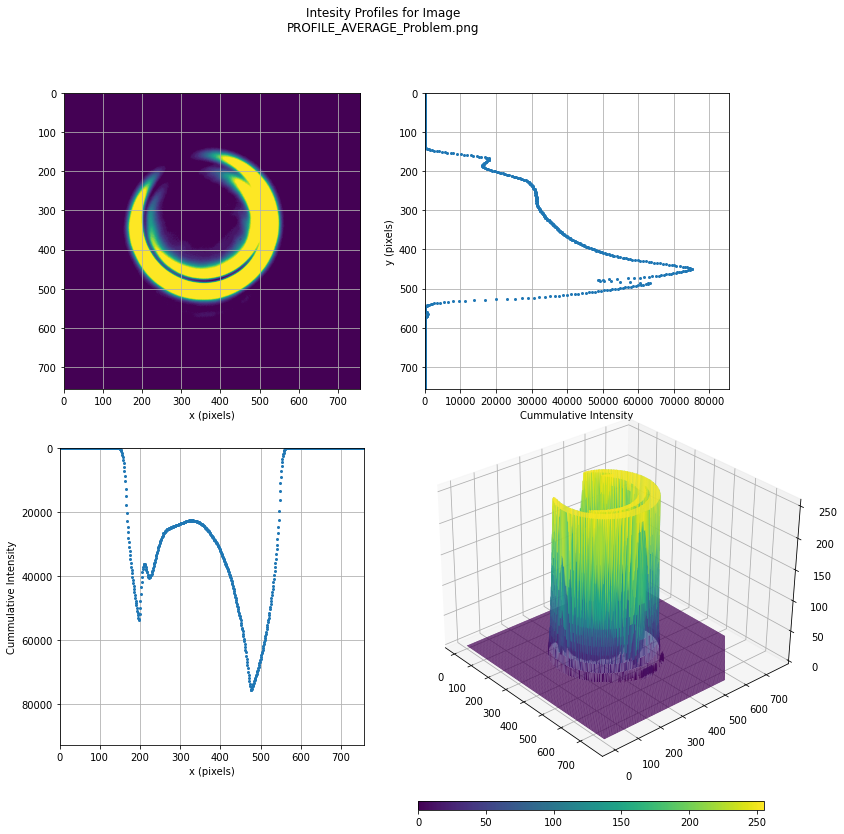

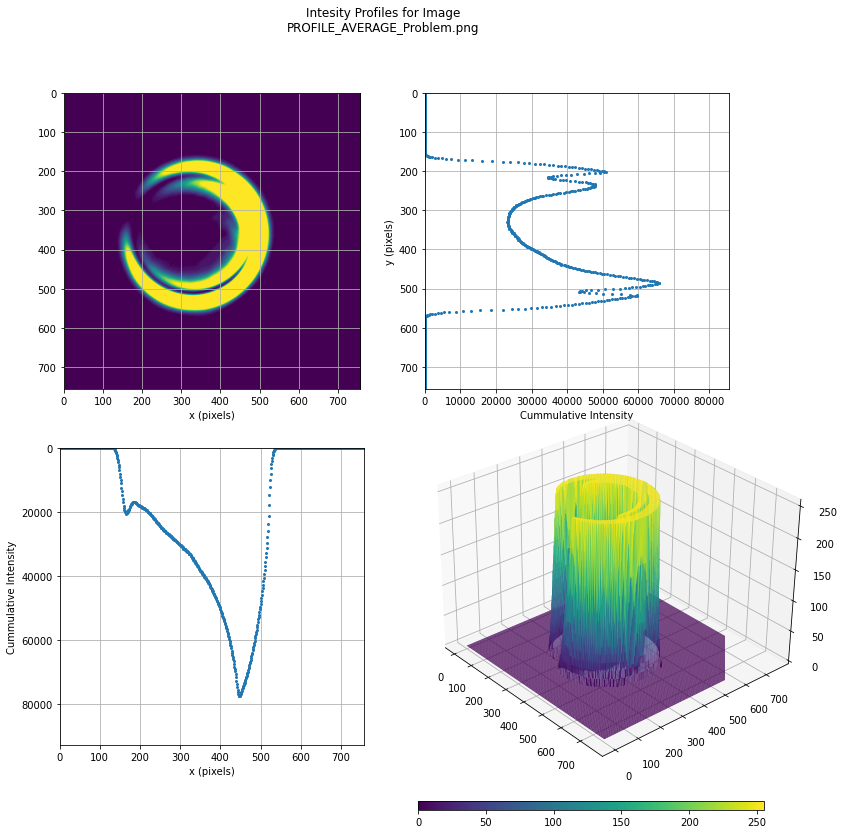

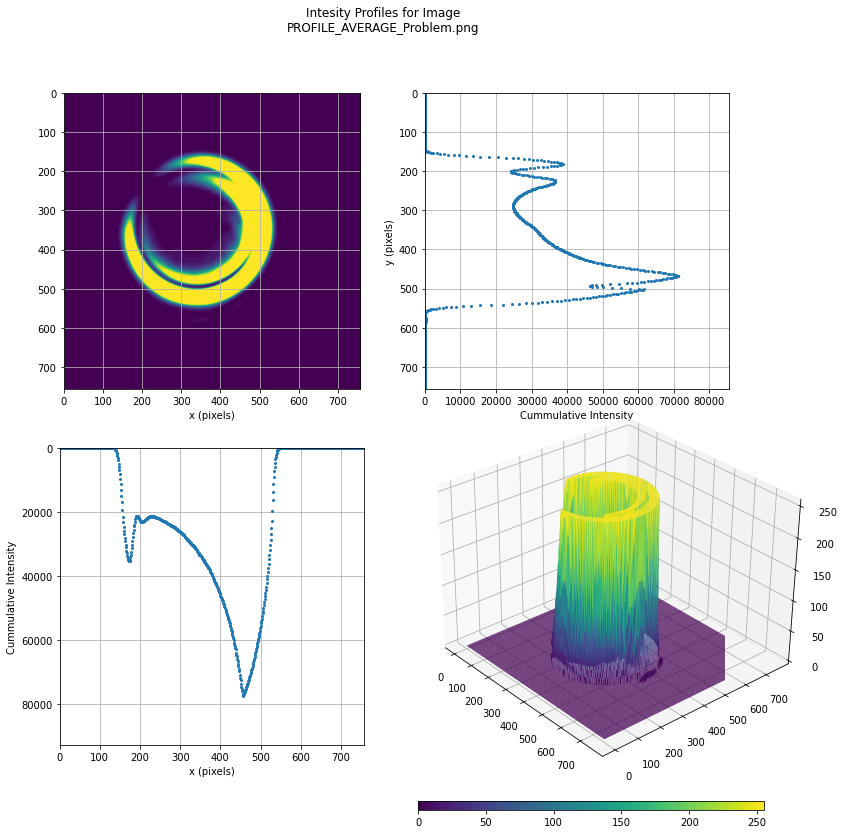

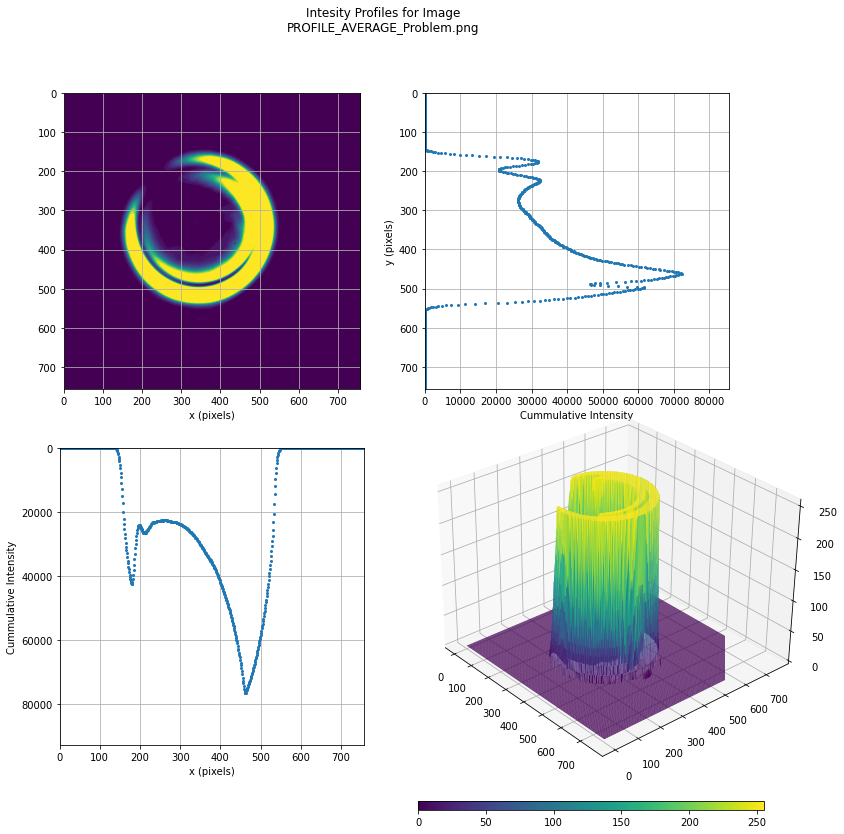

In [23]:
saturation=0.1
for choice, gt in zip(["Sin_Negativo", "Sin_Positivo", "Sin_Ambos", "Con_Ambos"],[-13.85, 9.45, 0, -4.4]):
    output_path=f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/Experimental_Stuff/Fotos_Turpin/Day2/laser_gaussian_thesis/Not_Saturated/{choice}"
    run_angle_live(output_path, gt, saturation, library_of_theoretical_path = "./OUTPUT/LIBRARIES_OF_THEORETICAL_CR/Basler_like_R0_158_w0_20_3th_decimal/STRUCTURE_Grid.json"
)

1. Gravicenters computed!



/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationW

2. Averge Images and Profiles Computed!

3. Raw Results Computed!

4. Final Results Computed!

   ground_truth averaged_images_or_angles  min_abs_theoretical_error  \
0            90                    angles                   1.962530   
1            90                    images                   2.753167   

   best_correct_decimals   best_algorithm  simulation_bf  mirror_fibo  \
0                      0  simulation_fibo      85.547907    85.464953   
1                      0  simulation_quad      85.547907    85.411949   

   mirror_quad  rotation_fibo  rotation_quad  simulation_fibo  simulation_quad  
0    85.464953      85.464953      85.472330        88.037470       -81.944406  
1    85.411949      85.411949      85.435947        87.075052        87.246833  


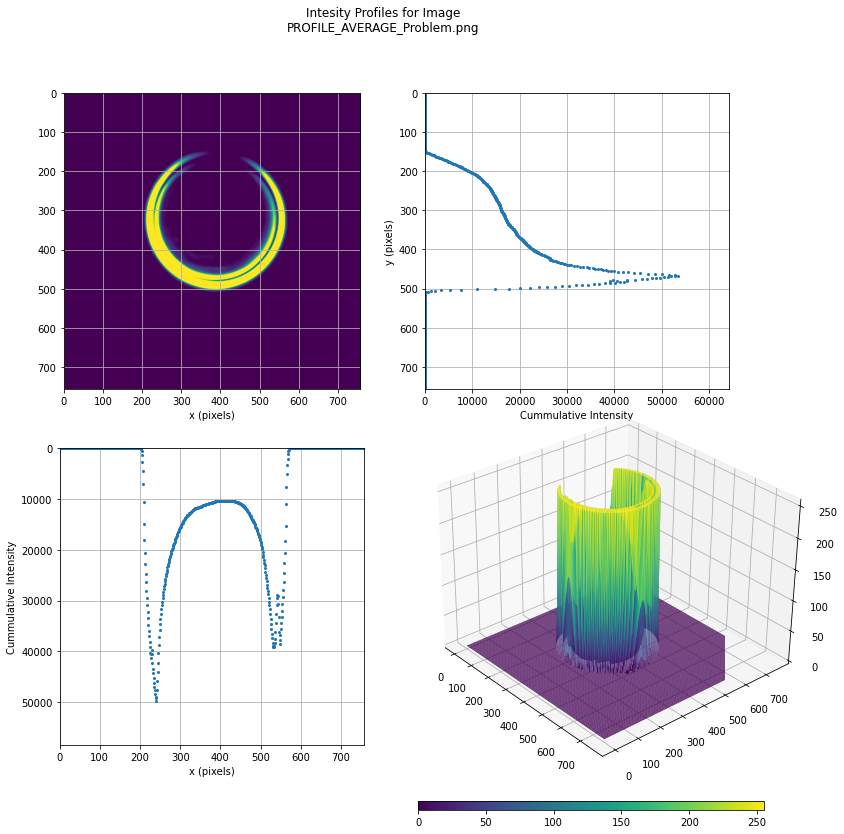

In [24]:
output_path=f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/Experimental_Stuff/Fotos_Turpin/Day3/"
run_angle_live(output_path, 90, saturation=0.1, library_of_theoretical_path = "./OUTPUT/LIBRARIES_OF_THEORETICAL_CR/Basler_like_R0_153_w0_11_3th_decimal/STRUCTURE_Grid.json")

1. Gravicenters computed!



/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationWarning:Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
/home/oiangu/anaconda3/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:95: DeprecationW

2. Averge Images and Profiles Computed!

3. Raw Results Computed!

4. Final Results Computed!

   ground_truth averaged_images_or_angles  min_abs_theoretical_error  \
1            90                    images                   1.074564   
0            90                    angles                   1.444064   

   best_correct_decimals   best_algorithm  simulation_bf  mirror_fibo  \
1                      1  simulation_fibo      88.555936    88.203999   
0                      0    simulation_bf      88.555936    88.238591   

   mirror_quad  rotation_fibo  rotation_quad  simulation_fibo  simulation_quad  
1    88.203999      88.203999      88.206766        88.925436       -88.809174  
0    88.238591      88.238591      88.243149       -77.870314       -57.460971  


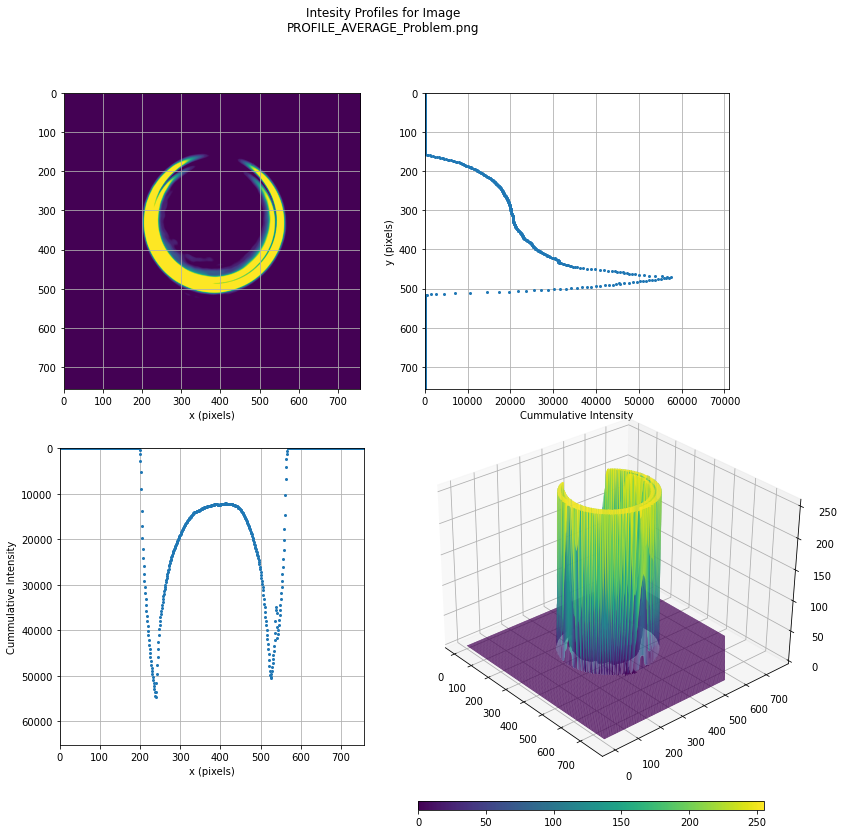

In [25]:
output_path=f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/Experimental_Stuff/Fotos_Turpin/Day3/"
run_angle_live(output_path, 90, saturation=0.05, library_of_theoretical_path = "./OUTPUT/LIBRARIES_OF_THEORETICAL_CR/Basler_like_R0_153_w0_11_3th_decimal/STRUCTURE_Grid.json")